In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="white")
from pyearth import Earth
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics as metrics
from scipy.stats import entropy
import math
from pyearth import export
from sympy import *
import copy
import matplotlib.transforms as transforms
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, PathPatch

In [63]:
data = pd.read_csv('/home/fotis/DATA/calls_data/coordinates.csv', sep=",", header=0)
data2 = pd.read_csv('/home/fotis/dev_projects/spark_test/target/calls_AVG_results/calls_queries_gau_gau_varl-0.0009_varx-0.0001/part-00000', sep=",", header = None)

In [64]:
data.columns = ['square_id','x','y']
data2.columns = ['x','y','l','avg','cardinality']
avgs = pd.read_csv('/home/fotis/DATA/calls_data/sms-call-internet-mi-2013-11-01.txt', sep="\t", header=None)
avgs.columns = ["square_id", "time_interval", "country_code", "smsin", "smsout", "callin", "callout", "internet_traffic"]

avgs.head(10)

,square_id,time_interval,country_code,smsin,smsout,callin,callout,internet_traffic
0,1,1383260400000,0,0.081363,NaN,NaN,NaN,NaN
1,1,1383260400000,39,0.141864,0.156787,0.160938,0.052275,11.028366
2,1,1383261000000,0,0.136588,NaN,NaN,0.027300,NaN
3,1,1383261000000,33,NaN,NaN,NaN,NaN,0.026137
4,1,1383261000000,39,0.278452,0.119926,0.188777,0.133637,11.100963
5,1,1383261600000,0,0.053438,NaN,NaN,NaN,NaN
6,1,1383261600000,39,0.330641,0.170952,0.134176,0.054601,10.892771
7,1,1383262200000,0,0.026137,NaN,NaN,NaN,NaN
8,1,1383262200000,39,0.681434,0.220815,0.027300,0.053438,8.622425
9,1,1383262800000,0,0.027300,NaN,NaN,NaN,NaN


In [65]:
data = data.set_index('square_id').join(avgs.groupby("square_id")['smsin'].mean())

In [83]:
data = data.dropna(axis=0, how='any')

In [84]:
data.isnull().sum()

x        0
y        0
smsin    0
dtype: int64

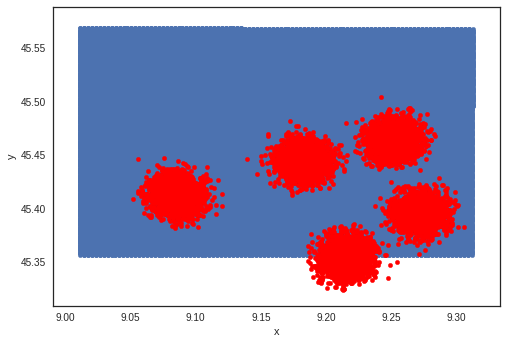

In [66]:
data2 = data2[data2['avg']>0]
data2 = data2.set_index(np.arange(data2.count()[0]))
data2 = data2.dropna(axis=0, how='all')
fig = plt.figure()
ax = fig.add_subplot(111)
data.plot(kind='scatter', x='x',y='y',ax=ax)
data2.plot(kind='scatter', x='x',y='y', c='r', ax=ax)

In [67]:
data2 = data2.convert_objects(convert_numeric=True)

/home/fotis/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


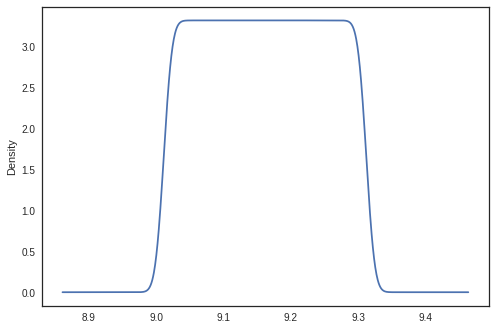

In [68]:
data.var()
data['x'].plot(kind='kde')

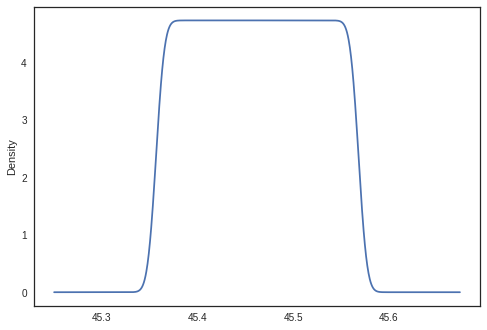

In [8]:
data['y'].plot(kind='kde')

In [69]:
min_of_average = data2['avg'].min()
max_of_average = data2['avg'].max()
xmin = data['x'].min()
xmax = data['x'].max()
ymin = data['y'].min()
ymax = data['y'].max()
lmin = data2['l'].min()
lmax = data2['l'].max()
print("Minimum avg : {0}\nMaximum avg : {1}".format(min_of_average, max_of_average))
print("Xmin :{0}\nXmax: {1}".format(xmin, xmax))
print("Ymin : {0}\nYmax : {1}".format(ymin, ymax))
print("Lmin : {0}\nLmax : {1}".format(lmin, lmax))

Minimum avg : 0.198043318724
Maximum avg : 5.37570119168
Xmin :9.01149061969
Xmax: 9.31268826419
Ymin : 45.3562617537
Ymax : 45.5682140755
Lmin : 0.0200416035807
Lmax : 0.179113678291


<h2>Normalizing values</h2></br>
$$X_{norma} = \frac{X - min(X)}{max(X) - min(X)}$$

In [70]:
#Normalize all values to (0,1)
# data['x'] = (data['x'] - xmin) / (xmax - xmin)
# data['y'] = (data['y'] - ymin) / (ymax - ymin)
#Normalize all values for queries to (0,1)
data2['x'] = (data2['x'] - xmin) / (xmax - xmin)
data2['y'] = (data2['y'] - ymin) / (ymax - ymin)
data2['l'] = (data2['l'] - lmin) / (lmax - lmin)
# data2['cardinality'] = (data2['cardinality'] - min_of_cardinality) / (max_of_cardinality - min_of_cardinality)

/home/fotis/.local/lib/python2.7/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


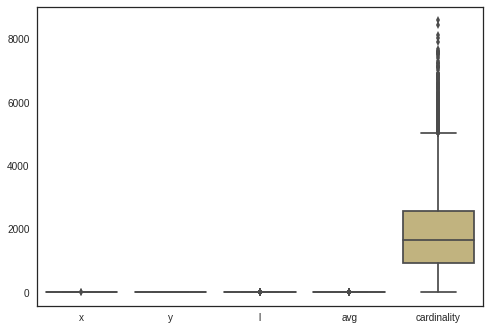

In [12]:
sns.boxplot(data2)

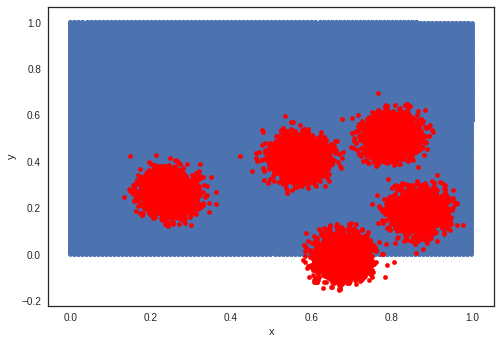

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
data.plot(kind='scatter', x='x',y='y',ax=ax)
data2.plot(kind='scatter', x='x',y='y', c='r', ax=ax)

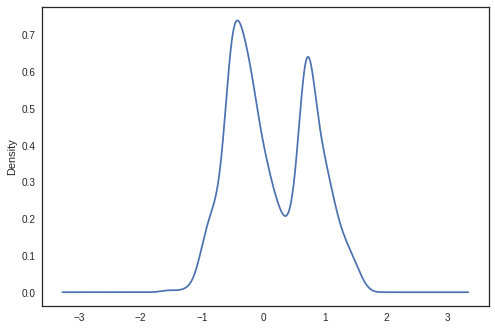

In [17]:
data2.avg.apply(np.log).plot(kind='kde')

<h2>Pre-Learning Phase 1st Level Clustering $$\mathbf{x}$$</h2></br>
<b>Cluster and train model for sample 0.2 of queries</b>

In [18]:
prelearningdf = data2.sample(frac=.2)
trainingdf = data2.drop(prelearningdf.index)

In [19]:
print("Resulting prelearning set : {0}\nResulting training set : {1}".format(prelearningdf.count()[0], trainingdf.count()[0]))

Resulting prelearning set : 2000
Resulting training set : 7998


<b>Resetting Indexes</b>

In [20]:
prelearningdf = prelearningdf.set_index(np.arange(prelearningdf.count()[0]))
trainingdf = trainingdf.set_index(np.arange(trainingdf.count()[0]))

In [21]:
X = prelearningdf[['x','y']].as_matrix()

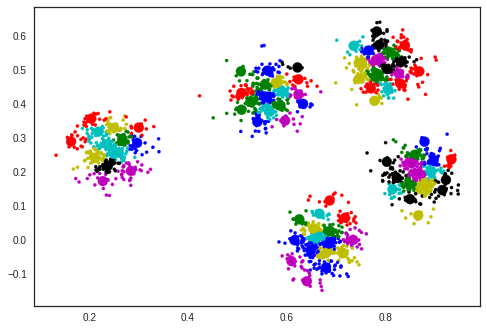

In [36]:
#Tuning k-parameter for kmeans
avg_vars = []
clusters_ = range(20,150,5)
vigil = 0.009
c=20
# # for c in clusters_:
# #     var = 0
# #     kmeans = MiniBatchKMeans(n_clusters=c, max_no_improvement=None)
# #     kmeans.fit(X)
# #     avg_vars.append(kmeans.inertia_)
# init = True
# diff = 1
# while diff>= vigil:
#     kmeans = MiniBatchKMeans(n_clusters=c, max_no_improvement=None)
#     kmeans.fit(X)
#     avg_vars.append(kmeans.inertia_)
#     if not init:
#         diff = (avg_vars[-2]-avg_vars[-1])
#     else:
#         init=False
#     c+=5
# c-= 5    
# avg_vars = np.array(avg_vars)
# selected = np.where(avg_vars == np.min(avg_vars))[0][0]
# print(selected)
# plt.plot(range(20,c+5,5), avg_vars)
# plt.plot(c, avg_vars[selected],'.g')
#End of tuning

CLUSTERS = 80#clusters_[selected]
kmeans = MiniBatchKMeans(n_clusters=CLUSTERS)
kmeans.fit(X)
if hasattr(kmeans, 'labels_'):
    y_pred = kmeans.labels_.astype(np.int)
else:
    y_pred = kmeans.predict(X)

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * CLUSTERS)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(prelearningdf['x'],prelearningdf['y'],color=colors[y_pred].tolist(), s=10)

if hasattr(kmeans, 'cluster_centers_'):
    centers = kmeans.cluster_centers_
    center_colors = colors[:len(centers)]
    plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)

plt.show()

<b>Assigning Queries to clusters</b>

In [38]:
clusters = {}
# fig, axs = plt.subplots(ncols=5, nrows=15,figsize=(30,25))
for i in range(len(kmeans.cluster_centers_)):
    item = np.where(kmeans.labels_== i)
    clusters[i] = prelearningdf.ix[item]
#     sns.regplot(x='l', y='cardinality', data=clusters[i],fit_reg=False, ax=axs[(i/5)][(i%5)])

In [39]:
for i in clusters:
    if clusters[i].count()[0]==0:
        print("Error found cluster with samples=0")

<b>Checking if cardinality variance is less within cluster than before</b>

In [40]:
#Is the variance lower when clustering ?
t = 0
for i in clusters:
    if clusters[i]['avg'].var() < data2['avg'].var():
        t+= 1
print("Variance lower when clustering : %d/%d , probability %f" % (t,len(kmeans.cluster_centers_), float(t)/len(kmeans.cluster_centers_)))

Variance lower when clustering : 78/80 , probability 0.975000


In [22]:
# for i in clusters:
#     print("Cluster {0}, variance : {1}".format(i,clusters[i]['cardinality'].var()))

<h2>Pre-Learning 2nd Level cluster $$\theta$$</h2>
<b>Cluster theta</b>

<b>Resetting indexes for each cluster because we need to re-cluster</b>

In [41]:
for i in clusters:
    clusters[i] = clusters[i].set_index(np.arange(clusters[i].count()[0]))

<b>Datastructure to hold each subcluster associated with a cluster</b>

<b>For every cluster, use a subclustering algorithm to cluster based on theta</b>

In [42]:
theta_centers = []
subclusters = []
#For each cluster
for j in clusters:
    T = clusters[j]['l'].as_matrix()
    #Tuning k-parameter for kmeans
    T = T.reshape(-1, 1)
    avg_vars = []
    clusters_ = range(1,4,1)
#     for c in clusters_:
#         var = 0
#         t_kmeans = MiniBatchKMeans(n_clusters=c, max_no_improvement=None)
#         t_kmeans.fit(T)
#         for i in range(len(t_kmeans.cluster_centers_)):
#             item = np.where(t_kmeans.labels_== i)
#             var += clusters[j].ix[item]['l'].var()
#         avg_vars.append(var/c)

#     avg_vars = np.array(avg_vars)
    selected = 2#np.where(avg_vars == np.min(avg_vars))[0][0]
#     plt.plot(clusters_, avg_vars)
#     plt.plot(clusters_[selected], avg_vars[selected],'.g')
    #End of tuning
    subcluster = []
    CLUSTERS = clusters_[selected]
    t_kmeans = MiniBatchKMeans(n_clusters=CLUSTERS)
    t_kmeans.fit(T)
    if hasattr(t_kmeans, 'labels_'):
        t_pred = t_kmeans.labels_.astype(np.int)
    else:
        t_pred = kmeans.predict(T)
    theta_centers.append(t_kmeans.cluster_centers_)
    for i in range(clusters_[selected]):
            item = np.where(t_kmeans.labels_== i)
            s = clusters[j].ix[item]
            subcluster.append(s)
        
    subclusters.append(subcluster)

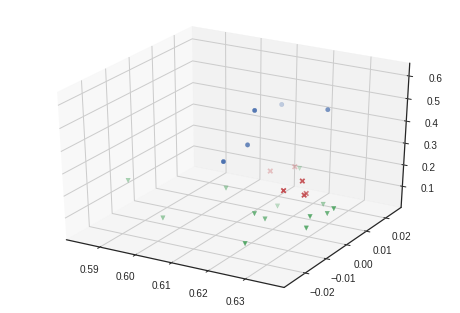

In [43]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
markers = ['o','v','x', '+']
# ax.scatter(clusters[0]['x'],clusters[0]['y'],color=colors[y_pred].tolist(), s=10)
i=0
for s in subclusters[0]:
        ax1.scatter(s['x'].as_matrix(),s['y'].as_matrix(),s['l'].as_matrix(), marker=markers[i])
        i+=1

In [ ]:
# n_cols = len(subclusters[0])
# fig, axs = plt.subplots(ncols=n_cols, nrows=len(subclusters),figsize=(30,25))
# sumc = 0
# for i in range(len(subclusters)):
#     for j in range(len(subclusters[i])):
#         cluster = subclusters[i][j]
#         ax=axs[i][0]
#         cluster['l'].plot(kind='kde',ax=ax)
#         print("Cluster {0}/{1} mean is {2}".format(i,j, cluster['l'].mean()*(lmax - lmin) + lmin))

<b>Count for every subcluster and resetting indexes</b>

In [44]:
for i in range(len(subclusters)):
    for j in range(len(subclusters[i])):
#         print("Count for subcluster {0}/{1} : {2}".format(i,j,subclusters[i][j].count()[0]))
        #Reset index trainingdf = trainingdf.set_index(np.arange(trainingdf.count()[0]))
        subclusters[i][j] = subclusters[i][j].set_index(np.arange(subclusters[i][j].count()[0])) 

<b>Creating MARS models (one per SUB-cluster)</b>

In [46]:
#Fit an Earth model for each cluster
# f, axarr = plt.subplots(10, 2,figsize=(35,35))
models = [{} for i in range(len(subclusters))]
r2_avg = 0
rmse_avg = 0
r2_for_model = {}
rmse_for_model = {}
for i in range(len(subclusters)):
    for j in range(len(subclusters[i])):
        tcluster = subclusters[i][j]
        tcluster = tcluster.dropna(axis=0, how='any')
        XX = tcluster['l'].as_matrix()
        yy = tcluster['avg'].as_matrix()
#         X_train, X_test, y_train, y_test = train_test_split(
#              XX, yy, test_size=0.1, random_state=42)
        model = Earth(max_degree=1)
        model.fit(XX,yy)
        models[i][j] = [model]
        y_hat = model.predict(XX)
        r2 = metrics.r2_score(yy, y_hat)
        rmse = np.sqrt(model.mse_)
        r2_for_model[i] = r2
        rmse_for_model[i] = rmse
        r2_avg+=r2
        rmse_avg+=rmse
#         print("Model for cluster {0} subcluster {4}, R2 : {1}, RMSE :{2}, Size of Sample : {3}".format(i,r2,rmse,tcluster.count()[0],j))

In [ ]:
# n_cols = len(subclusters[0])
# fig, axs = plt.subplots(ncols=n_cols, nrows=len(subclusters),figsize=(30,25))
# sumc = 0
# for i in range(len(subclusters)):
#     for j in range(len(subclusters[i])):
#         cluster = subclusters[i][j]
#         sumc+= cluster.count()[0]
#         ax=axs[i][0]
#         sns.regplot(x='l', y='cardinality', data=cluster,fit_reg=False, ax=ax)
#         ax.plot(cluster['l'], models[i][j][0].predict(cluster['l'].as_matrix()), '.g')

In [47]:
#PROBELMATIC len of sublcusters might not be the same for each subcluster
print("Average R2 : %f" % (r2_avg/(len(subclusters*len(subclusters[0])))))
print("Average RMSE : %f" % (rmse_avg/(len(subclusters*len(subclusters[0])))))

Average R2 : 0.603937
Average RMSE : 0.055574


<h2>Training phase</h2>

In [48]:
testingdf = trainingdf.sample(frac=.2)
trainingdf = trainingdf.drop(testingdf.index)
print("Resulting training set : {0}\nResulting testing set : {1}".format(trainingdf.count()[0], testingdf.count()[0]))

Resulting training set : 6398
Resulting testing set : 1600


In [49]:
trainingdf = trainingdf.set_index(np.arange(trainingdf.count()[0]))
testingdf = testingdf.set_index(np.arange(testingdf.count()[0]))

In [50]:
online = trainingdf.dropna(axis=0, how='any').as_matrix()

<h3>Switch Between Scenarios</h3>

In [51]:
selected_scenario = 2

In [ ]:
# # temp = theta_centers[0]
# # temp1 = theta_centers[1]
# # t_matrix = np.vstack((temp.T, temp1.T))
# # print(np.linalg.norm(theta_centers - q0[2],axis=1))
# # print(kmeans.cluster_centers_)
# # print(t_matrix)
# # print(np.array(theta_centers[0]))t
# t_matrix = np.vstack((theta_centers[0].T, theta_centers[1].T))
# for t in theta_centers[2:]:
#     t_matrix = np.vstack((t_matrix, t.T))
# print(t_matrix)
# # print(ones + (t_matrix-q[0])**2)
# # print(np.linalg.norm(tmatrix - q0[2],axis=1))

<b>Scenario 1 </b>
- First go to closest clusterhead
$$w_k = argmin_k \lVert \mathbf{w}_k - \mathbf{x'} \rVert $$ 
- Then go to theta clusterhead with the smallest prediction error
$$\theta_{k,j} = argmin_j (\hat{y_{k,j}} - y)^2$$

<b>Scenario 2</b>
- Go to closest clusterhead 
$$w_k = argmin_k \lVert \mathbf{w}_k - \mathbf{x'} \rVert $$ 
- Go to theta clusterhead with the miunimum prediction error and distance from query's theta. <b>Lambda</b> is a tunable parameter
$$\theta_{k,j} = argmin_j  \lambda(\theta'-\theta_{k,j})^2 + (1-\lambda)(\hat{y_{k,j}} - y')^2$$

In [52]:
if selected_scenario == 2:
    print("Executing Scenario 2")
    #Reset cluster centers as well
    ALPHA = 0.01
    LAMBDA = 0.5
    subclusters_copy = copy.deepcopy(subclusters)
    theta_centers_copy = copy.deepcopy(theta_centers) #theta positions (multiple for each clusterhead)
    cluster_centers = copy.copy(kmeans.cluster_centers_) # x posistions of clusterheads
    new_models = copy.deepcopy(models)
    n_s = 20
    t = 1 # every 20 , retrain ONLY affected MARS models
    affected = [] #Keep a list of affected models to retrain only them
    keys = ['x','y','l','avg']
    traces_centers = []
    traces_centers.append(cluster_centers) # Initialize Positions
    traces_theta = []
    traces_theta.append(theta_centers_copy)
    trace_affected_x = []
    trace_affected_y = []
    additions = [] # 6 dimensional qx, qy, ql , cx, cy, cl (q=query, c=clusterhead)
    side_experiment_counter = 0
    for q in online:
        dist = np.linalg.norm(cluster_centers - q[:2],axis=1) #Calculate distances between all neurons
        closest_x = np.argmin(dist)
        #Scenario 2 Go to closest X and then to theta with lowest error
        dist_t = ((theta_centers_copy[closest_x]-q[2])**2).T
        preds = []
        for m in new_models[closest_x]:
            preds.append(float(new_models[closest_x][m][-1].predict([q[2]])))
    #     preds = [float(new_models[m][-1].predict([q[2]])) for m in new_models] #Prediction for each latest model
        preds = np.array(preds)
        errors = np.sqrt((preds-q[3])**2) #Error between prediction and each model (y-y_hat)**2
        #Normalize errors
        errors = (errors-min_of_average) / (max_of_average-min_of_average)
    #     total_distance = dist.reshape(len(subclusters),1) + dist_t # Distance from x  + distance from theta cluster
    #     errors = errors.reshape((len(subclusters),len(subclusters[0])))
    #     tot_error = 0.3*(total_distance) + 0.7*(errors) #Total error
    #     closest = np.unravel_index(tot_error.argmin(), tot_error.shape)
        total_distance = LAMBDA*dist_t +  (1-LAMBDA)*errors # Distance from x  + distance from theta cluster
        closest_t = np.argmin(total_distance)
        closest = (closest_x, closest_t)
        #Side experiment : number of times closest distance wise gives smallest prediction error
        distwise = np.argmin(dist_t)
        errorwise = np.argmin(errors)
        side_experiment_counter+= distwise==errorwise
        #Adding to cluster
        dictionarize = dict(zip(keys, q.T))
        subclusters_copy[closest[0]][closest[1]] = subclusters_copy[closest[0]][closest[1]].append(dictionarize, 
                                                                                                   ignore_index=True)
        #Readjust theta
        theta_centers_copy[closest[0]][closest[1]] += ALPHA*(q[2] - theta_centers_copy[closest[0]][closest[1]])
        traces_theta.append(copy.copy(theta_centers_copy))
        trace_affected_x.append(closest[0])
        trace_affected_y.append(closest[1])
        #Retraining every n_s steps
        affected.append(closest)
        if (t%n_s)==0:
            for tpl in set(affected):
                model = Earth(max_degree=1)
                subclusters_copy[tpl[0]][tpl[1]] = subclusters_copy[tpl[0]][tpl[1]].dropna(axis=0, how='any')
                xtrain_o = subclusters_copy[tpl[0]][tpl[1]]['l'].as_matrix()
                ytrain_o = subclusters_copy[tpl[0]][tpl[1]]['avg'].as_matrix()
    #             #Readjusting clusterhead
    #             #Cannot extract mean of each subcluster, need to store sum and count for each and then compute mean.
    #             cluster_centers[tpl[0]] = pd.concat(subclusters_copy[tpl[0]]).mean()[:2]
    #             traces_centers.append(copy.copy(cluster_centers))
                new_models[tpl[0]][tpl[1]].append(model.fit(xtrain_o, ytrain_o)) #Append a new model
            affected = []
        t+=1

Executing Scenario 2


In [53]:
#Side experiment results
print("Probability of closest distance wise thetaclusterhead having the smallest error {0}".format(side_experiment_counter /len(online)))

Probability of closest distance wise thetaclusterhead having the smallest error 0


In [ ]:
# print("Total queries in clusters : {0}".format(sumc))

<h2>Evaluation of advanced clustering algorithm on prediction</h2>

In [54]:
onlinetest = testingdf.dropna(axis=0, how='any').as_matrix()

In [55]:
y_pred = []
y_actual = onlinetest[:,3]
for q in onlinetest:
    dist = np.linalg.norm(cluster_centers - q[:2],axis=1) #Calculate distances between all neurons
    closest_x = np.argmin(dist)
    dist_t = (theta_centers_copy[closest_x]-q[2])**2
    closest_t = np.argmin(dist_t)
    y_hat = new_models[closest_x][closest_t][-1].predict([q[2]])
    y_pred.append(y_hat[0])
y_pred = np.array(y_pred)
print("R2 : {0}\nMSE: {1}".format(metrics.r2_score(y_actual, y_pred), np.sqrt(metrics.mean_squared_error(y_actual, y_pred))))

R2 : 0.981220342589
MSE: 0.128878637019


In [85]:
qs = testingdf[['x','y','l']].as_matrix()
data_asm = data.groupby(data.index)['x', 'y', 'smsin'].mean().dropna(axis=0, how='any').as_matrix()

In [86]:
data_asm = data.reset_index()[['x', 'y', 'smsin','square_id']].as_matrix()

In [88]:
q = data2.as_matrix()[0]
print(q)
l_denorm = q[2]*(lmax - lmin) + lmin
x_denorm = q[0]*(xmax - xmin) + xmin
y_denorm = q[1]*(ymax - ymin) + ymin
q_denorm = np.array([x_denorm, y_denorm, l_denorm])

print(x_denorm)
print(y_denorm)
print(l_denorm)
#Create subqueries with smaller thetas starting from 0.01(init point of training) up to theta
squeries = np.linspace(lmin, l_denorm, 10) #CHANGED TO 0.02
y_Test_a = []
print(q_denorm)
#Execute thetas and get actual y for stationary query
distances_for_y = np.sqrt(np.float64(np.sum(np.power(data_asm[:,:2]-q_denorm[:2],2),axis=1)))
data_within = data_asm[distances_for_y < q_denorm[2]]
print(data_within.shape)
df = pd.DataFrame(data_within,columns=['x','y','smsin','square_id'])
print(np.mean(df.groupby('square_id')['smsin'].mean().as_matrix()))
# for theta in squeries:
# #         dist_filter = distances_for_y[distances_for_y < theta]
# #         y_real = len(dist_filter)
#     #For Average
#     if len(data_asm[distances_for_y < theta][:,2])==0:
#         y_real = 0
#     else:
#         y_real = np.mean(data_asm[distances_for_y < theta][:,2])
#     y_Test_a.append(y_real)
# y_Test_a = np.array(y_Test_a)
print(squeries)
print(y_Test_a)

[  7.58557042e-01   6.10330095e-01   7.99408321e-04   3.13015855e+00
   2.36000000e+02]
9.23996621389
45.4856226345
0.0201687671209
[  9.23996621e+00   4.54856226e+01   2.01687671e-02]
(1015, 4)
3.1301585454
[ 0.0200416   0.02005573  0.02006986  0.02008399  0.02009812  0.02011225
  0.02012638  0.02014051  0.02015464  0.02016877]
[]


<h2>Begining evaluation on explanations</h2>

In [89]:
import time

avg_r2_me = 0
avg_r2_god = 0
avg_r2_knn = 0
avg_kl = 0
k_nn = 25
avg_r2_new = 0
probs = []
avg_relative_error = 0
LAMBDA_P = 0.5
record_times_closest = 0
not_giving_expl = 0
threshold = 0.001
sub_thetas = 10

#For all queries in testingdf
for q in qs:
    #Get closest clusters

    dist = np.linalg.norm(cluster_centers - q[:2],axis=1) #Calculate distances between all neurons
    closest_x = np.argmin(dist)
    dist_t = (theta_centers_copy[closest_x]-q[2])**2
    close_t_b = np.argmin(total_distance)
    #Record
    distwise = np.argmin(dist_t)
    record_times_closest+= distwise==closest_t
    l_denorm = q[2]*(lmax - lmin) + lmin
    x_denorm = q[0]*(xmax - xmin) + xmin
    y_denorm = q[1]*(ymax - ymin) + ymin
    q_denorm = np.array([x_denorm, y_denorm, l_denorm])
    #First denormalize theta 
    #Create subqueries with smaller thetas starting from 0.01(init point of training) up to theta
    squeries = np.linspace(lmin, l_denorm, 10) #CHANGED TO 0.02
    y_Test_a = []
    #Execute thetas and get actual y for stationary query
    start_time = time.time()
    for theta in squeries:
        distances_for_y = np.sqrt(np.float64(np.sum(np.power(data_asm[:,:2]-q_denorm[:2],2),axis=1)))
        data_within = data_asm[distances_for_y < theta]
        #For Average
        if len(data_within)==0:
            y_real = 0
        else:
            df = pd.DataFrame(data_within,columns=['x','y','smsin','square_id'])
            df = df.dropna(how="any", axis=0)
            y_real = np.mean(df.groupby('square_id')['smsin'].mean().as_matrix())
        y_Test_a.append(y_real)
    y_Test_a = np.array(y_Test_a)

    t_of_execution_ac = time.time() - start_time
#     y_Test_a = (y_Test_a - min_of_cardinality) / (max_of_cardinality - min_of_cardinality)

    #Normalize squeries
    squeries = (squeries - lmin) / (lmax - lmin)
    #Create PLR for GOD
    model_god = Earth(max_degree=1, penalty=0, enable_pruning=False, max_terms=sub_thetas)
    model_god.fit(squeries, y_Test_a)
    god_predi = model_god.predict(squeries)
#     print(model_god.summary())
    #Create subqueries to be executed
    #Each query is executed from the same position but with a lesser theta
    mqueries = np.matrix([q] * sub_thetas)
    qqs = squeries.reshape((sub_thetas,1))
    mqueries[:,2] = 0
    mqueries[:,2] = qqs  
    #ME MARS MODEL
    #Change of strategy get closest model for each lesser theta.
    y_predi_c = []
    start_time = time.time()
    closests = []
    for theta in squeries:
        dist_t = (theta_centers_copy[closest_x]-theta)**2
        closest_t = np.argmin(dist_t)
        closests.append(closest_t)
        prediction = float(new_models[closest_x][closest_t][-1].predict([theta]))
        if prediction>0:
            y_predi_c.append(prediction)
        else:
            y_predi_c.append(0)
    t_of_execution_me = time.time() - start_time
    

    y_predi_c = np.array(y_predi_c)
#     y_predi_c = new_models[closest_x][closest_t][-1].predict(squeries)
#     y_predi_c[np.where(y_predi_c < 0)] = y_predi_c[np.where(y_predi_c < 0)] * -1 * 0
#     y_predi_c = y_predi_c*(max_of_cardinality - min_of_cardinality) + min_of_cardinality


    

    
    #knn  
    i = 0
    start_time = time.time()
    lr = LinearRegression()
    lr.fit(squeries.reshape(-1,1), y_Test_a)  
    knn_predi = lr.predict(squeries.reshape(-1,1))
#     cc = clusters[closest_x].as_matrix()
#     for m in mqueries :        
#         dist_for_qs = np.sqrt(np.sum(np.power(cc[:,:3]-m,2),axis=1))
#         sorted_indices = np.argsort(dist_for_qs.flatten())
#         knn_predi.append(np.mean(np.squeeze(cc[sorted_indices])[:k_nn,3]))
#         i+=1
#     knn_predi = np.array(knn_predi)
    t_of_execution_knn = time.time() - start_time
    
#     knn_predi = knn_predi*(max_of_cardinality - min_of_cardinality) + min_of_cardinality

    #Evaluation Scores
    relative_error_for_slope_me = 0
    relative_error_for_slope_knn = 0
    relative_error_for_slope_g = 0
    
    #Slope of god
    for i in range(1,len(god_predi[1:])):
        #Slope
        paronomastis = squeries[i] - squeries[i-1]
        arithmitis = y_Test_a[i] - y_Test_a[i-1]
        #Predicted_slope
        arithmitis_me = y_predi_c[i] - y_predi_c[i-1]
        arithmitis_knn = knn_predi[i] - knn_predi[i-1]
        arithmitis_g = god_predi[i] - god_predi[i-1]
        v = arithmitis/paronomastis
        vapprox_m = arithmitis_me/paronomastis
        vapprox_knn = arithmitis_knn/paronomastis
        vapprox_g = arithmitis_g/paronomastis
        #Relative error
        relative_error_for_slope_me+= np.abs(1-vapprox_m/v)
        relative_error_for_slope_knn+= np.abs(1-vapprox_knn/v)
        relative_error_for_slope_g+= np.abs(1-vapprox_g/v)
        
    relative_error_for_slope_me = relative_error_for_slope_me/float(i+1)
    relative_error_for_slope_knn = relative_error_for_slope_knn/float(i+1)
    relative_error_for_slope_g = relative_error_for_slope_g/float(i+1)

    
    
    #KL-divergence metric
    kl_divergence = entropy(y_Test_a, y_predi_c)
    kl_div_g = entropy(y_Test_a, god_predi)
    kl_div_knn = entropy(y_Test_a, knn_predi)
    entropy_p = entropy(y_Test_a)
    scaler = 1.0/entropy_p

    #R2 scores
    knn_r2_score = metrics.r2_score(y_Test_a, knn_predi )
    me_r2_score = metrics.r2_score(y_Test_a, y_predi_c)
    god_r2_score = metrics.r2_score(y_Test_a, god_predi)
    
    new_metric_m = 1 - ((np.sum(np.abs(y_Test_a - y_predi_c)))/(np.sum(np.abs(y_Test_a - np.mean(y_Test_a)))))
    new_metric_g = 1 - ((np.sum(np.abs(y_Test_a - god_predi)))/(np.sum(np.abs(y_Test_a - np.mean(y_Test_a)))))
    new_metric_knn = 1 - ((np.sum(np.abs(y_Test_a - knn_predi)))/(np.sum(np.abs(y_Test_a - np.mean(y_Test_a)))))

#     print(entropy_p)
#     print(kl_divergence)
#     print(kl_divergence*scaler)
#     print(knn_r2_score)
#     print(me_r2_score)
#     print(god_r2_score)
#     print(relative_error_for_slope_me)
#     print(y_Test_a)
#     print(y_predi_c)
#     print(np.var(y_Test_a))
#     print(np.mean(y_Test_a))
#     print(metrics.r2_score(y_Test_a, y_predi_c))
#     fig = plt.figure(figsize=(14,5))
#     ax = fig.add_subplot(111)
#     ax.plot(squeries, y_Test_a, 'y', label='Actual Explanation')
#     print(closests)
# #     ax.plot(squeries, god_predi, 'k')
#     print(squeries)
#     ax.set_ylabel("y")
#     ax.set_xlabel("Theta")
#     ax.plot(squeries[:7], new_models[closest_x][1][-1].predict(squeries[:7]),'--k', label='Model 1')
#     ax.plot(squeries[7:], new_models[closest_x][0][-1].predict(squeries[7:]),'--b', label='Model 0')
#     ax.plot(squeries, new_models[closest_x][close_t_b][-1].predict(squeries),'-*g', label='Single Model')
#     ax.plot(squeries, y_predi_c, 'g')
#     ax.plot(squeries, new_models[closest_x][close_t_b][-1].predict(squeries), 'b')
#     ax.plot(squeries[-1], y_Test_a[-1],'.k')
#     ax.plot(squeries, y_Test_a, 'b',label='Actual Explanation - Took : {0} seconds'.format(t_of_execution_ac))
#     print("tac: {0}".format(t_of_execution_ac))
#     print("tme: {0}".format(t_of_execution_me))
#     plt.title("How cardinality changes with respect to theta")

#     plt.plot(squeries, god_predi, 'g')
#     ax = fig.add_subplot(122)
#     ax.plot(squeries[-1], y_Test_a[-1],'.k')
#     ax.set_ylabel("y")
#     ax.set_xlabel("Theta")
#     ax.plot(squeries, y_Test_a, 'b',label='Actual Explanation - Took : {0} seconds'.format(t_of_execution_ac))
#     ax.plot(squeries, y_predi_c, 'y', label='Approximate Explanation - Took : {0} seconds'.format(t_of_execution_me))
#     plt.plot(squeries, knn_predi, '--k', label='linear')
#     plt.plot(squeries, y_predi_c, '-*g', label='me')
#     plt.plot(squeries, god_predi, 'y', label='god')
#     plt.plot(squeries, y_Test_a, 'b', label='actual')
#     plt.legend()
#     break;
    #Averages
    avg_kl += kl_divergence
    avg_r2_knn += knn_r2_score
    avg_r2_me += me_r2_score
    avg_r2_god += god_r2_score
    avg_relative_error+=relative_error_for_slope_me
    avg_r2_new+=new_metric_m
    probs.append([closest_x, closest_t, me_r2_score, god_r2_score, knn_r2_score, 
                  new_metric_m, new_metric_g, new_metric_knn,
                  relative_error_for_slope_me, relative_error_for_slope_knn, relative_error_for_slope_g,
                  kl_divergence, kl_div_g, kl_div_knn,entropy_p, scaler,
                  t_of_execution_ac,t_of_execution_me, t_of_execution_knn, q[0], q[1], q[2], np.var(y_Test_a)])
    

print("Average R2 knn : %f" % (avg_r2_knn/len(qs)))    
print("Average R2 ME : %f" % (avg_r2_me/len(qs)))
print("Average R2 GOD : %f" % (avg_r2_god/len(qs)))
print("Average R2' : %f" % (avg_r2_new/len(qs)))
print("Average relative error for slope :%f" % (avg_relative_error/len(qs)))
print("Side experiment probability of closest being chosen : %f" % (float(record_times_closest)/len(qs)))

/home/fotis/.local/lib/python2.7/site-packages/ipykernel/__main__.py:129: RuntimeWarning: invalid value encountered in double_scalars
/home/fotis/.local/lib/python2.7/site-packages/ipykernel/__main__.py:129: RuntimeWarning: invalid value encountered in absolute
/home/fotis/.local/lib/python2.7/site-packages/ipykernel/__main__.py:130: RuntimeWarning: divide by zero encountered in double_scalars
/home/fotis/.local/lib/python2.7/site-packages/ipykernel/__main__.py:131: RuntimeWarning: divide by zero encountered in double_scalars
/home/fotis/.local/lib/python2.7/site-packages/ipykernel/__main__.py:129: RuntimeWarning: divide by zero encountered in double_scalars
/home/fotis/.local/lib/python2.7/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars
/home/fotis/.local/lib/python2.7/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in absolute
/home/fotis/.local/lib/python2.7/site-packages/ipykernel/__main__.py:13

Average R2 knn : 0.716183
Average R2 ME : -38768380315251719224818663424.000000
Average R2 GOD : 0.716558
Average R2' : -4922421934072.695312
Average relative error for slope :nan
Side experiment probability of closest being chosen : 0.345000


In [90]:
print(len(qs))
print(not_giving_expl)

1600
0


In [91]:
past_probs = copy.deepcopy(probs)

In [92]:
sdf = pd.DataFrame(data=np.array(probs), index=range(len(probs)), columns=['closest_x','closest_t','r2_me','r2_god','r2_knn',
                                                                           'new_metric_m','new_metric_g', 'new_metric_knn',
                                                                           'slope_error_me','slope_error_knn', 'slope_error_g',
                                                                           'KL_m','kl_g','kl_knn',
                                                                           'entropy_p','scaler', 
                                                                           'time_g','time_me','time_knn',
                                                                           'x','y','l','var'])

In [96]:
sdf.median()

closest_x          37.000000
closest_t           1.000000
r2_me               0.607417
r2_god              0.872401
r2_knn              0.872401
new_metric_m        0.393295
new_metric_g        0.644856
new_metric_knn      0.644856
slope_error_me      0.894159
slope_error_knn     0.973669
slope_error_g       0.973669
KL_m                0.001299
kl_g                0.001129
kl_knn              0.001129
entropy_p           2.294062
scaler              0.435908
time_g              0.019928
time_me             0.000498
time_knn            0.000259
x                   0.672863
y                   0.261897
l                   0.299732
var                 0.016699
dtype: float64

0.881246022722
-0.0146557654934
0.881246022722


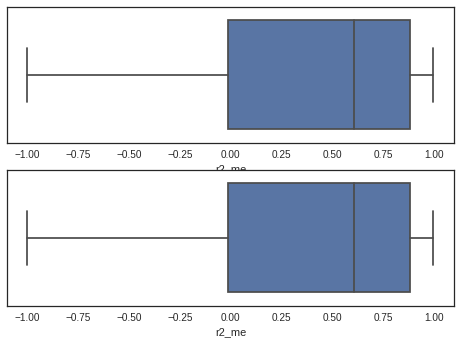

In [7]:
# data['update_in_days'].plot(kind='hist')
Q3 = sdf.r2_me.quantile(.75)
Q1 = sdf.r2_me.quantile(.25)
IQR = Q3 - Q1
print(Q3)
print(Q1)
print(Q3)
outlier_point_max = Q3+ 1.5 * IQR
outlier_point_min = Q1-1.5*IQR
fig = plt.figure()
ax = fig.add_subplot(211)
sns.boxplot(sdf.r2_me,ax=ax)
# sdf = sdf[sdf.r2_me < outlier_point_max]
sdf = sdf[sdf.r2_me > outlier_point_min]
ax = fig.add_subplot(212)
sns.boxplot(sdf.r2_me,ax=ax)

In [97]:
sdf.to_csv(path_or_buf='/home/fotis/Dropbox/PhD/10.July - 2017/eval_results/gau_gau-AVG-Over-Calls.csv')

In [4]:
sdf = pd.read_csv('/home/fotis/Dropbox/PhD/10.July - 2017/eval_results/gau_gau-AVG-Over-Calls.csv')

In [267]:
sdf['cardinality'] = testingdf['avg']
# sdf['mse'] = sdf.apply(lambda x: np.sqrt(new_models[int(x['closest_x'])][int(x['closest_t'])][-1].mse_), axis=1)

In [268]:
sdf = sdf.replace([np.inf, -np.inf], np.nan).dropna()

In [5]:
sdf.sort_values('r2_me')

,Unnamed: 0,closest_x,closest_t,r2_me,r2_god,r2_knn,new_metric_m,new_metric_g,new_metric_knn,slope_error_me,...,kl_knn,entropy_p,scaler,time_g,time_me,time_knn,x,y,l,var
841,1054,28.0,0.0,-1.704662,0.217599,0.217599,-0.977679,0.098730,0.098730,1.991147,...,0.002017,2.300024,0.434778,0.019857,0.000359,0.000252,0.862064,0.314109,0.329010,0.004078
486,603,25.0,2.0,-1.690930,0.981715,0.981715,-0.485058,0.867913,0.867913,0.888889,...,0.000382,2.280464,0.438507,0.017427,0.000359,0.000248,0.622925,-0.055866,0.161662,0.008269
275,344,35.0,1.0,-1.674004,0.919587,0.919587,-0.466437,0.722506,0.722506,0.888889,...,0.000624,2.295111,0.435709,0.021788,0.000454,0.000472,0.290822,0.306588,0.198869,0.021552
250,314,20.0,1.0,-1.670314,0.979274,0.979274,-0.504555,0.867019,0.867019,0.888889,...,0.000121,2.296799,0.435388,0.018402,0.000358,0.000260,0.826073,0.204282,0.132465,0.005545
1015,1261,29.0,2.0,-1.669474,0.755738,0.755738,-0.498003,0.501781,0.501781,1.776335,...,0.001432,2.296559,0.435434,0.018952,0.000362,0.000249,0.790832,0.468643,0.239502,0.037013
674,842,38.0,2.0,-1.648407,0.327628,0.327628,-0.865459,0.084606,0.084606,2.746222,...,0.000481,2.301875,0.434428,0.019213,0.000364,0.000254,0.825956,0.151114,0.242372,0.000452
296,373,40.0,1.0,-1.645305,0.256293,0.256293,-0.747489,0.110992,0.110992,1.738329,...,0.000190,2.302330,0.434343,0.018061,0.000560,0.000258,0.670590,-0.029503,0.010999,0.000073
826,1033,22.0,2.0,-1.634403,0.032804,0.032804,-0.538312,0.034499,0.034499,1.112200,...,0.003523,2.298950,0.434981,0.021952,0.000368,0.000254,0.251810,0.288520,0.457617,0.005840
773,966,35.0,0.0,-1.630628,0.527566,0.527566,-0.652554,0.295831,0.295831,1.789291,...,0.000874,2.300711,0.434648,0.022467,0.000656,0.000343,0.284996,0.274555,0.261002,0.003401
857,1072,3.0,2.0,-1.628451,0.009283,0.009283,-0.771009,0.035020,0.035020,0.890489,...,0.001845,2.300722,0.434646,0.019467,0.000368,0.000255,0.265555,0.261405,0.261769,0.002461


In [ ]:
sdf.iloc[sdf[np.isinf(sdf)].dropna(how='all').index,:]

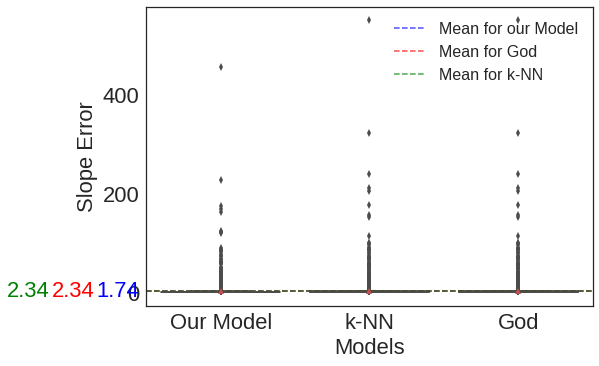

In [269]:
ddf = sdf[['slope_error_me','slope_error_knn','slope_error_g']].stack().to_frame('slope_error')
ddf = ddf.reset_index(level=1)
# ddf['closest'] = sdf.ix[ddf.index]['closest']
# ddf['l'] = sdf.ix[ddf.index]['l']
# ax = sns.boxplot(x="level_1", y="r2", data=ddf)
# ddf= ddf[ddf['slope_error']<1]
# sdf = sdf[sdf['slope_error_me']<1]
font_size = 22
ax = sns.boxplot(x="level_1", y="slope_error", data=ddf, showmeans=True)
trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
mr2 = sdf['slope_error_me'].mean()
ax.axhline(y=mr2, color="b", alpha=0.6, linestyle='--' ,label='Mean for our Model')
ax.text(0,mr2, "{:.2f}".format(mr2), color="b", transform=trans, 
        ha="right", va="center", size=font_size)

gr2 = sdf['slope_error_g'].mean()
ax.axhline(y=gr2, color="r", alpha=0.6, linestyle='--',label='Mean for God')
ax.text(-0.1,gr2, "{:.2f}".format(gr2), color="r", transform=trans, 
        ha="right", va="center", size=font_size)
kr2 = sdf['slope_error_knn'].mean()
ax.axhline(y=kr2, color="g", alpha=0.6, linestyle='--',label='Mean for k-NN')
ax.text(-0.2,kr2, "{:.2f}".format(kr2), color="g", transform=trans, 
        ha="right", va="center", size=font_size)
ax.set_xlabel("Models",size=font_size)
ax.set_ylabel("Slope Error",size=font_size)


labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Our Model'
labels[1] = 'k-NN'
labels[2] = 'God'

ax.set_xticklabels(labels)
ax.tick_params(labelsize=font_size)
ax.legend(prop={'size':16})

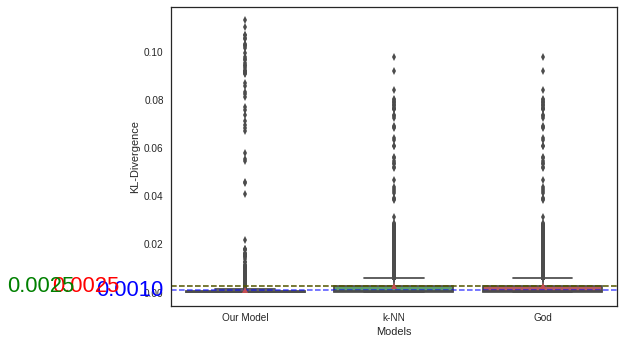

In [270]:
ddf = sdf[['KL_m','kl_knn','kl_g']].stack().to_frame('KL-Divergence')
ddf = ddf.reset_index(level=1)
# ddf['closest'] = sdf.ix[ddf.index]['closest']
# ddf['l'] = sdf.ix[ddf.index]['l']
# ax = sns.boxplot(x="level_1", y="r2", data=ddf)
# ddf= ddf[ddf['KL-Divergence']<0.10]
ax = sns.boxplot(x="level_1", y="KL-Divergence", data=ddf, showmeans=True)
trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
mr2 = sdf['KL_m'].mean()
ax.axhline(y=mr2, color="b", alpha=0.6, linestyle='--' ,label='Mean for our Model')
ax.text(0,mr2, "{:.4f}".format(mr2), color="b", transform=trans, 
        ha="right", va="center", size=font_size)
gr2 = sdf['kl_g'].mean()
ax.axhline(y=gr2, color="r", alpha=0.6, linestyle='--',label='Mean for God')
ax.text(-0.1,gr2, "{:.4f}".format(gr2), color="r", transform=trans, 
        ha="right", va="center", size=font_size)
kr2 = sdf['kl_knn'].mean()
ax.axhline(y=kr2, color="g", alpha=0.6, linestyle='--',label='Mean for k-NN')
ax.text(-0.2,kr2, "{:.4f}".format(kr2), color="g", transform=trans, 
        ha="right", va="center", size=font_size)
ax.set_xlabel("Models")
ax.set_ylabel("KL-Divergence")


labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Our Model'
labels[1] = 'k-NN'
labels[2] = 'God'

ax.set_xticklabels(labels)

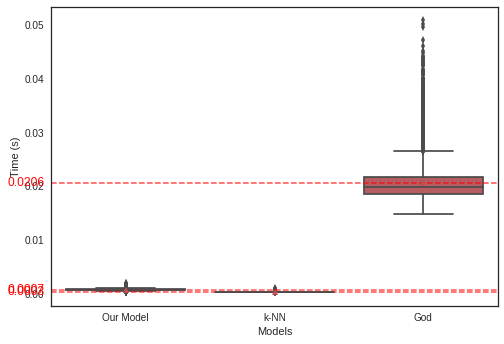

In [271]:
ddf = sdf[['time_me','time_knn','time_g']].stack().to_frame('time')
ddf = ddf.reset_index(level=1)
# ddf['closest'] = sdf.ix[ddf.index]['closest']
# ddf['l'] = sdf.ix[ddf.index]['l']
# ax = sns.boxplot(x="level_1", y="r2", data=ddf)
ax = sns.boxplot(x="level_1", y="time", data=ddf, showmeans=True)
trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
mr2 = sdf['time_me'].mean()
ax.axhline(y=mr2, color="red", alpha=0.6, linestyle='--')
ax.text(0,mr2, "{:.4f}".format(mr2), color="red", transform=trans, 
        ha="right", va="center")
gr2 = sdf['time_g'].mean()
ax.axhline(y=gr2, color="red", alpha=0.6, linestyle='--')
ax.text(0,gr2, "{:.4f}".format(gr2), color="red", transform=trans, 
        ha="right", va="center")
kr2 = sdf['time_knn'].mean()
ax.axhline(y=kr2, color="red", alpha=0.6, linestyle='--')
ax.text(0,kr2, "{:.4f}".format(kr2), color="red", transform=trans, 
        ha="right", va="center")
ax.set_xlabel("Models")
ax.set_ylabel("Time (s)")


labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Our Model'
labels[1] = 'k-NN'
labels[2] = 'God'

ax.set_xticklabels(labels)

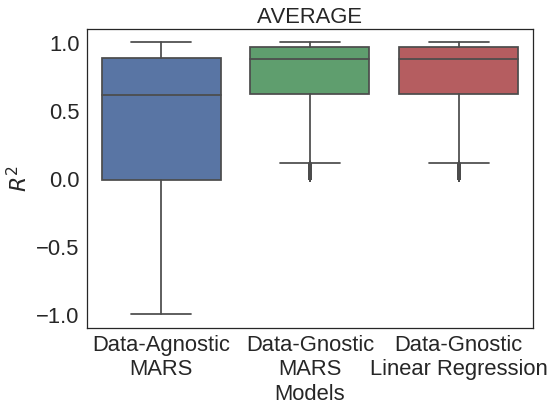

In [15]:
sdf[sdf[['r2_me','r2_god', 'r2_knn']] <-1] = -1
# sdf = pd.read_csv('/home/fotis/dev_projects/spark_test/target/evaluation_10000_from_x/results_gau_gau_-x.csv', sep=",", header=0)
# sns.regplot(x='l', y='r2_me', data=sdf, fit_reg=False, x_bins=20, logx=True, label='me')
# sns.regplot(x='l', y='r2_knn', data=sdf, fit_reg=False, x_bins=20, logx=True, label='knn')
# sns.regplot(x='l', y='r2_god', data=sdf, fit_reg=False, x_bins=20, logx=True, label='god')
# sns.regplot(x='l', y='r2_lin', data=sdf, fit_reg=False, x_bins=20, logx=True, label='lin')
# plt.title('Gau X with variance :0.01\nGau theta : with mean 0.04 and variance : 0.0001')
# plt.xlabel('theta')
# plt.ylabel('R2')
# plt.legend()
# sdf.to_csv("/home/fotis/dev_projects/spark_test/target/evaluation_10000_from_x_advanced/results_gau_gau_-x.csv")
ddf = sdf[['r2_me','r2_god','r2_knn']].stack().to_frame('r2')
ddf = ddf.reset_index(level=1)
# ddf['closest'] = sdf.ix[ddf.index]['closest']
# ddf['l'] = sdf.ix[ddf.index]['l']
# ax = sns.boxplot(x="level_1", y="r2", data=ddf)
# plt.ylim(0.9,1)
ax = sns.boxplot(x="level_1", y="r2", data=ddf, showmeans=False, )
trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)

mr2 = sdf['r2_me'].mean()
# ax.axhline(y=mr2, color="red", alpha=0.6, linestyle='--')
# ax.text(0,mr2, "{:.2f}".format(mr2), color="red", transform=trans, 
#         ha="right", va="center")

gr2 = sdf['r2_god'].mean()
# ax.axhline(y=gr2, color="red", alpha=0.6, linestyle='--')
# ax.text(0,gr2, "{:.2f}".format(gr2), color="red", transform=trans, 
#         ha="right", va="center")
kr2 = sdf['r2_knn'].mean()
# ax.axhline(y=kr2, color="red", alpha=0.6, linestyle='--')
# ax.text(0,kr2, "{:.2f}".format(kr2), color="red", transform=trans, 
#         ha="right", va="center")
font_size=22
ax.set_xlabel("Models",size=font_size)
ax.set_ylabel(r"$R^2$",size=font_size)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Data-Agnostic\nMARS'
labels[1] = 'Data-Gnostic\nMARS'
labels[2] = 'Data-Gnostic\nLinear Regression'
ax.set_title("AVERAGE",size=font_size)

ax.set_xticklabels(labels)
ax.tick_params(labelsize=font_size)
ax.set_xlabel("Models", fontsize=font_size)
ax.set_ylabel(r"$R^2$", fontsize=font_size)
ax.legend(prop={'size':16})

In [1]:
sdf[sdf[['new_metric_m','new_metric_g', 'new_metric_knn']] <-1] = -1
# sdf = pd.read_csv('/home/fotis/dev_projects/spark_test/target/evaluation_10000_from_x/results_gau_gau_-x.csv', sep=",", header=0)
# sns.regplot(x='l', y='r2_me', data=sdf, fit_reg=False, x_bins=20, logx=True, label='me')
# sns.regplot(x='l', y='r2_knn', data=sdf, fit_reg=False, x_bins=20, logx=True, label='knn')
# sns.regplot(x='l', y='r2_god', data=sdf, fit_reg=False, x_bins=20, logx=True, label='god')
# sns.regplot(x='l', y='r2_lin', data=sdf, fit_reg=False, x_bins=20, logx=True, label='lin')
# plt.title('Gau X with variance :0.01\nGau theta : with mean 0.04 and variance : 0.0001')
# plt.xlabel('theta')
# plt.ylabel('R2')
# plt.legend()
# sdf.to_csv("/home/fotis/dev_projects/spark_test/target/evaluation_10000_from_x_advanced/results_gau_gau_-x.csv")
ddf = sdf[['new_metric_m','new_metric_g','new_metric_knn']].stack().to_frame('r2_new')
ddf = ddf.reset_index(level=1)
# ddf['closest'] = sdf.ix[ddf.index]['closest']
# ddf['l'] = sdf.ix[ddf.index]['l']
# ax = sns.boxplot(x="level_1", y="r2", data=ddf)
ax = sns.boxplot(x="level_1", y="r2_new", data=ddf, showmeans=True)
trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)

mr2 = sdf['new_metric_m'].mean()
ax.axhline(y=mr2, color="red", alpha=0.6, linestyle='--')
ax.text(0,mr2, "{:.2f}".format(mr2), color="red", transform=trans, 
        ha="right", va="center")

gr2 = sdf['new_metric_g'].mean()
ax.axhline(y=gr2, color="red", alpha=0.6, linestyle='--')
ax.text(0,gr2, "{:.2f}".format(gr2), color="red", transform=trans, 
        ha="right", va="center")
kr2 = sdf['new_metric_knn'].mean()
ax.axhline(y=kr2, color="red", alpha=0.6, linestyle='--')
ax.text(0,kr2, "{:.2f}".format(kr2), color="red", transform=trans, 
        ha="right", va="center")
ax.set_xlabel("Models")
ax.set_ylabel("Alternative to Coefficient Of Determination")


labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Our Model'
labels[1] = 'God'
labels[2] = 'k-NN'

ax.set_xticklabels(labels)

NameError: name 'sdf' is not defined

In [ ]:
from matplotlib import cm
cmap = cm.get_cmap('jet')
# sdf[sdf['r2_me']<0]['closest_t'].plot(kind='kde')
sdf['mse'] = sdf.apply(lambda x: np.sqrt(new_models[int(x['closest_x'])][int(x['closest_t'])][-1].mse_), axis=1)
# sdf[sdf['r2_me']<0][sdf['closest_t']==0].plot(kind='scatter',x='closest_x',y='closest_t', c='mse',  colormap=cmap)
print(sdf[sdf['r2_me']<0]['l'].mean())
sdf['l'].plot(kind='kde')
sdf[sdf['r2_me']<0]['l'].plot(kind='kde')

In [ ]:
# sns.boxplot(testingdf[testingdf['l']]['cardinality'])
# sdf[sdf['r2_me']>-5000][sdf['r2_me']<0].plot(kind='scatter', x='l', y='r2_me')
# sns.boxplot(testingdf[testingdf['l']<0.08]['cardinality'])
sdf['thresh'] = sdf.apply(lambda x: np.abs(x['cardinality']-testingdf['cardinality'].mean()), axis=1)
sdf.plot(kind='scatter', x='cardinality', y='r2_me')


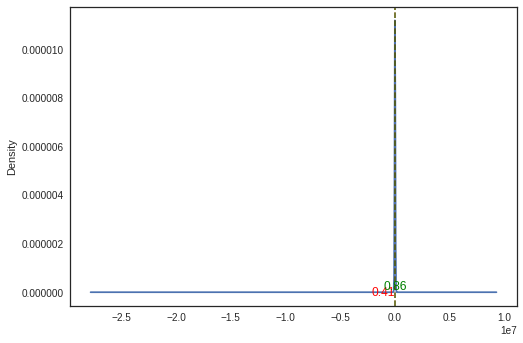

In [276]:
ax = sdf['r2_me'].plot(kind='kde')
medeianmr2 = sdf['r2_me'].median()
trans = transforms.blended_transform_factory(
    ax.get_xticklabels()[0].get_transform(), ax.transData)
ax.axvline(x=mr2, color="red", alpha=0.6, linestyle='--')
ax.text(mr2,0, "{:.2f}".format(mr2), color="red", transform=trans, 
        ha="right", va="center")
ax.axvline(x=medeianmr2, color="green", alpha=0.6, linestyle='--')
ax.text(medeianmr2,0, "{:.2f}".format(medeianmr2), color="green", transform=trans, 
        ha="center", va="bottom")

In [ ]:
sdf['slope_error']=sdf['slope_error'].replace([np.inf, -np.inf], np.nan)
ax = sdf['slope_error'].dropna().plot(kind='kde')
slopeerrorme = sdf['slope_error'].dropna().median()
slopeerrormean = sdf['slope_error'].dropna().mean()
trans = transforms.blended_transform_factory(
    ax.get_xticklabels()[0].get_transform(), ax.transData)
ax.axvline(x=slopeerrormean, color="red", alpha=0.6, linestyle='--')
ax.text(slopeerrormean,0, "{:.2f}".format(slopeerrormean), color="red", transform=trans, 
        ha="right", va="center")
ax.axvline(x=slopeerrorme, color="green", alpha=0.6, linestyle='--')
ax.text(slopeerrorme,0, "{:.2f}".format(slopeerrorme), color="green", transform=trans, 
        ha="left", va="bottom")
ax.set_title("Slope Error")

In [ ]:
ratio=sdf['KL']*sdf['scaler']
ratio=ratio.replace([np.inf, -np.inf], np.nan)
ax = ratio.dropna().plot(kind='kde')
ratiomedian = ratio.dropna().median()
ratiomean = ratio.dropna().mean()
trans = transforms.blended_transform_factory(
    ax.get_xticklabels()[0].get_transform(), ax.transData)
ax.axvline(x=ratiomean, color="red", alpha=0.6, linestyle='--')
ax.text(ratiomean,0, "{:.4f}".format(ratiomean), color="red", transform=trans, 
        ha="right", va="center")
ax.axvline(x=ratiomedian, color="green", alpha=0.6, linestyle='--')
ax.text(ratiomedian,0, "{:.4f}".format(ratiomedian), color="green", transform=trans, 
        ha="left", va="bottom")
ax.set_title("KL")

In [ ]:
sdf['KL']=sdf['KL'].replace([np.inf, -np.inf], np.nan)
ax = sdf['KL'].dropna().plot(kind='kde')
ratiomedian = sdf['KL'].dropna().median()
ratiomean = sdf['KL'].dropna().mean()
trans = transforms.blended_transform_factory(
    ax.get_xticklabels()[0].get_transform(), ax.transData)
ax.axvline(x=ratiomean, color="red", alpha=0.6, linestyle='--')
ax.text(ratiomean,0, "{:.4f}".format(ratiomean), color="red", transform=trans, 
        ha="right", va="center")
ax.axvline(x=ratiomedian, color="green", alpha=0.6, linestyle='--')
ax.text(ratiomedian,0, "{:.4f}".format(ratiomedian), color="green", transform=trans, 
        ha="left", va="bottom")
ax.set_title('Ratio')